# Introduction

The Local Ocean Conservation - Sea Turtle Face Detection on Zindi challenges participants to build an algorithm capable of drawing a bounding box around the all-important facial scales of a sea turtle. 

In this notebook we'll look at the data and build a very basic solution.

## Loading the data
 First of all we need to load the images in our notebook. I placed both the images and the csv file in the relative path ./dataset/

In [1]:
from PIL import Image, ImageDraw
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
image_folder = './dataset/IMAGES_1024'

In [3]:
# Load train - edit path to suit your setup
train = pd.read_csv('./dataset/Train.csv')
print(train.shape)
train.head()

(1326, 5)


Image_ID         x         y         w         h
0  04FB1B33  0.481988  0.506076  0.174696  0.405671
1  B04E481E  0.617405  0.313368  0.177734  0.293113
2  32655645  0.490885  0.465856  0.165582  0.357350
3  44D4DA7C  0.472873  0.506076  0.237847  0.409722
4  4F36EF72  0.433811  0.574363  0.180773  0.397569

# View an Image

Let's check that we have the images where we expect them, and plot a bounding box to visualize our goal here:

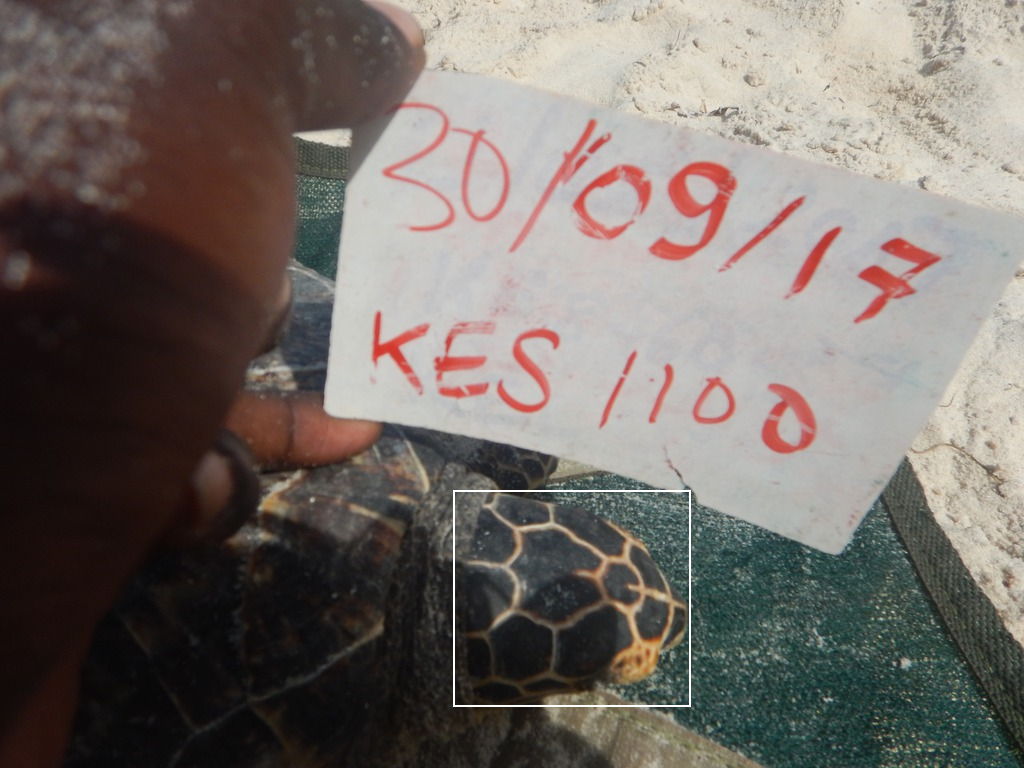

In [4]:
# Take a sample row
imid, x, y, w, h = train.sample().values[0]

# Open with PIL and draw a bounding box
with Image.open(f'{image_folder}/{imid}.JPG') as im:
  imw, imh = im.size # Box coords are relative to image size
  draw = ImageDraw.Draw(im)
  draw.rectangle([int(x*imw), int(y*imh), int((x+w)*imw), int((y+h)*imh)], width=2)
im

## A Useful Library: Keras_Cv

Working with Computer Vision tasks (and object detection in particular) is quite hard.
For this reason, Keras has released a new library: keras_cv.

KerasCV's primary goal is to provide a coherent, elegant, and pleasant API to train state of the art computer vision models relying only on the tensorflow API.
assist in common computer vision tasks such as data-augmentation, classification, object detection, image generation, and more.
It allows to develop training and inference state-of-the art models and pipelines for tasks such as Augmentation, Object Detection, Image Segmentation and Image Classification.

We will use keras_cv for this task

Let us first install keras_cv

In [3]:
!pip install git+https://github.com/keras-team/keras-cv

/bin/bash: /home/alberto/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Cloning https://github.com/keras-team/keras-cv to /tmp/pip-req-build-z3cmxcex
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-cv /tmp/pip-req-build-z3cmxcex
  Resolved https://github.com/keras-team/keras-cv to commit a93f425a2e344dcc2231e7679c905be4dd8af098
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for keras-core from https://files.pythonhosted.org/packages/4e/53/58ffc04e861174034485d5cd4a9cdbb95f9788000ed7ca26c784be2a0d32/keras_core-0.1.0-py3-none-any.whl.metadata
  Using cached keras_core-0.1.0-py3-none-any.whl.metadata (3.9 kB)
  Obtaining dependency information for rich from https://files.pythonhosted.org/packages/fc/1e/482e5eec0b89b593e81d78f819a9412849814e22225842b598908e7ac560/rich-13.4.2-py

We now import the libraries we will need in the process

In [5]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
import keras_cv
import cv2
import numpy as np
from keras_cv import bounding_box
import pandas as pd

from keras_cv import visualization

Using TensorFlow backend


In [6]:
# Checking if the GPU is seen by the jupyter notebook (useful to check the correct installation of all the packages and the drivers for using tensorflow with the GPU).
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Definition of the hyperparameters of the model

In [7]:
# Size of the batch
BATCH_SIZE = 16
# Percentage of the training set to use as training set (the remainder will be used for the size of the validation set)
TRAIN_SPLIT = 0.8
# This value must be defined accordingly to the size that the learner takes in input. For many networks it's usually 224
INPUT_SIZE_LEARNER = 224

## Loading of the dataset

The first step is loading the dataset.
While this may seem a trivial step, when using a pretrained it is really important to be careful to the input desired by the pretrained model (on which kind of data it was trained).

In this case all the models have been pretrained on:
  - images with the 3 channels in the range [0, 255]
  - the location of the bounding boxes are in the range [0, IMG_WIDTH] and [0, IMG_HEIGHT]
  - the data will be a dictionary (useful for plotting later on the images, not required by the model)

In [29]:
def load_dataset(training=True):
    # define the base path to the input dataset and then use it to derive
    # the path to the images directory and annotation CSV file
    BASE_PATH = "dataset"
    IMAGES_PATH = os.path.sep.join([BASE_PATH, "IMAGES_1024"])
    if training:
        ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Train.csv"])
    else:
        ANNOTS_PATH = os.path.sep.join([BASE_PATH, "SampleSubmission.csv"])

    # load the contents of the CSV annotations file
    print("[INFO] loading dataset...")
    rows = open(ANNOTS_PATH).read().strip().split("\n")
    # initialize the list of data (images), our target output predictions
    # (bounding box coordinates), along with the filenames of the
    # individual images
    data = []
    targets = []
    sizes = []

    # Remove the first row containing "ID, x, y, w, h"
    rows = rows[1:]

    for row in rows:
        # Split the fields of the .csv file
        row = row.split(',')
        filename = row[0]
        # Convert the coordinates from strings to floats
        coordinates = [float(v) for v in row[1:]]
        
        imagePath = os.path.sep.join([IMAGES_PATH, filename+'.JPG'])

        # Load the image of the desired size
        image = tf.keras.preprocessing.image.load_img(imagePath, target_size=(INPUT_SIZE_LEARNER, INPUT_SIZE_LEARNER))
        image = tf.keras.preprocessing.image.img_to_array(image)
        
        data.append(image)

        # If training get the coordinates, otherwise get the size for making the prediction as absolute values once you get the offset in range [0,1]
        if training:
            # scale the bounding box coordinates relative to the spatial
            # dimensions of the input image
            startX = coordinates[0] * INPUT_SIZE_LEARNER
            startY = coordinates[1] * INPUT_SIZE_LEARNER
            endX = (coordinates[0]+coordinates[2]) * INPUT_SIZE_LEARNER
            endY = (coordinates[1]+coordinates[3]) * INPUT_SIZE_LEARNER

            targets.append((startX, startY, endX, endY))

    if training:
        dataset = tf.data.Dataset.from_tensor_slices((data, targets))
        dataset = dataset.map(lambda d,t: {'images':d, 'bounding_boxes': {'classes':tf.constant([0]), 'boxes':tf.reshape(t,[1,4])}})
    else:
        dataset = tf.data.Dataset.from_tensor_slices(data)
    
    print("[INFO] dataset loaded.")
    return dataset, len(data)

In [9]:
# Create the list with the names of the classes associated to the IDs used in the prediction.
# In our case we are predicting only turtles, so that will be the only element in this list
class_ids = ["Turtle"]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

Let's now load the data and see if plotting the images results in what we are actually expecting or if we did some mistakes in the definition of the loading methods.

Furthermore, we divide our dataset into training and testing.

In [10]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs['images'], inputs['bounding_boxes']
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

# Load the dataset
dataset, data_size = load_dataset(training=True)

# Splitting the dataset into training and validation
train_size = int(data_size * TRAIN_SPLIT)
val_size = int(data_size * (1 - TRAIN_SPLIT))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)

[INFO] loading dataset...
[INFO] dataset loaded.


Let's batch now our data.
In object detection when using the Keras, it is recommended to use ragged batch of inputs. This is due to the fact that there may be different numbers of bounding boxes per image.

In [11]:
# Shuffle the training set
train_ds = train_ds.shuffle(train_size)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

Finally, we can visualize the dataset.

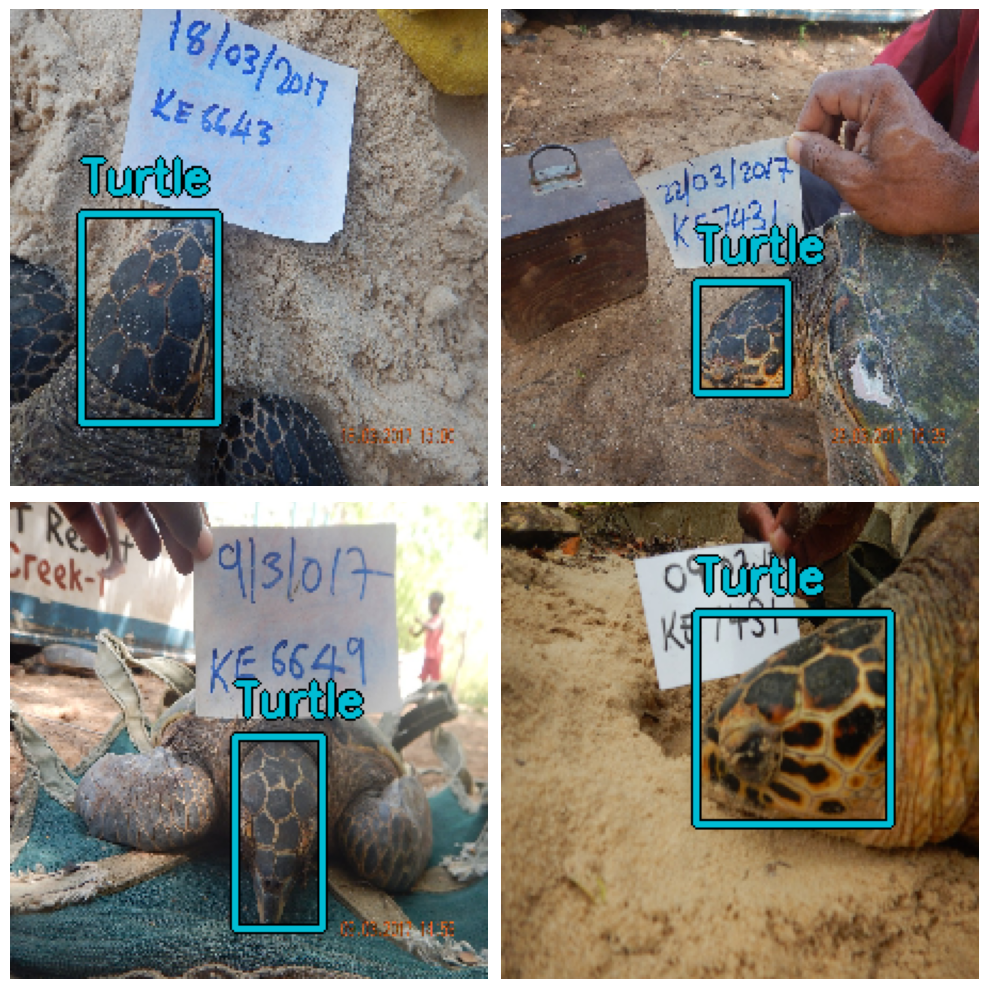

In [12]:
# Visualize the dataset by using the function we defined above.
# The training set
visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

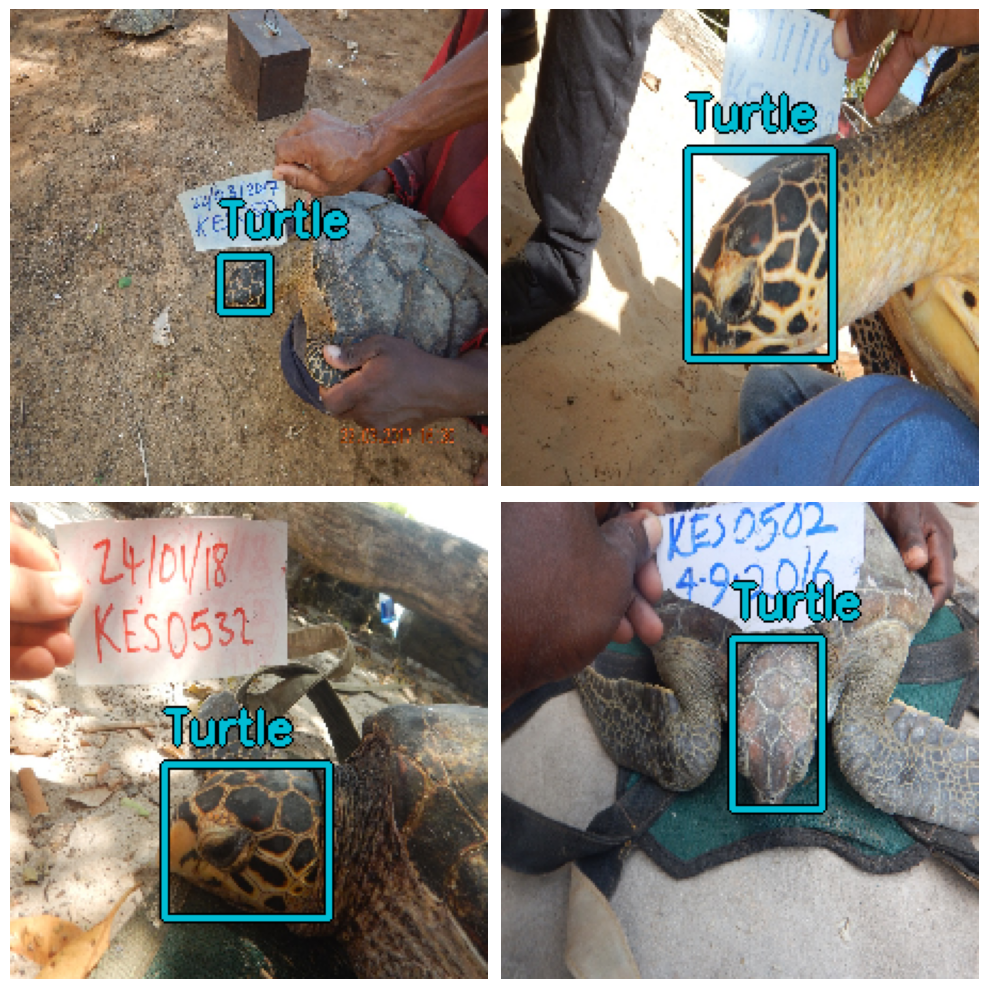

In [13]:
# And validation set
visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

## Data Augmentation pipeline

Data Augmentation is the task of artificially generating samples in order to prevent the model from overfitting.
We want to modify the samples in such a way that the network instead of learning by heart the images, will try to understand the actual pattern and how the head of the turtle is done.

For image classification this is easy, while for object detection the task can be quite tedious as the modification of the image implies also the modification of the coordinates of the bounding box.
With keras_cv augmentation is made easier and is handled by the library itself.

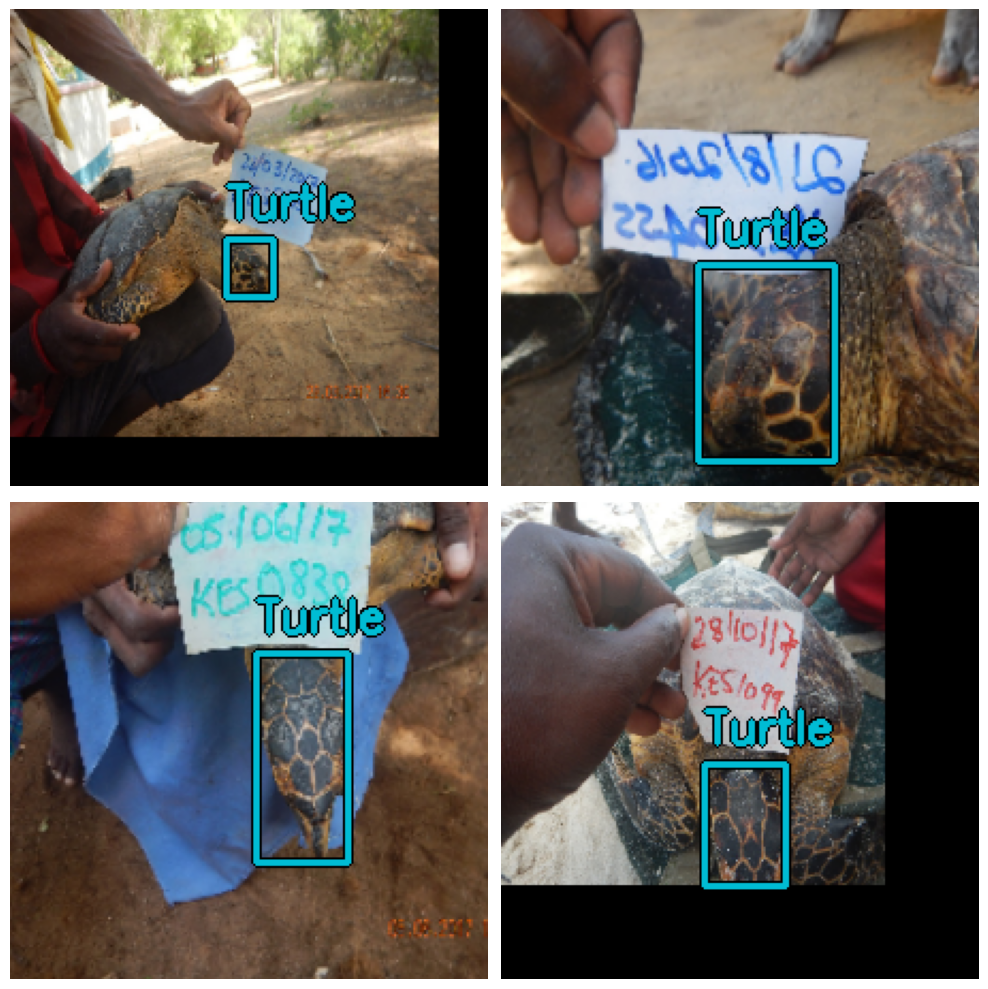

In [14]:
# Augmentation pipeline
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(224, 224), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
        #keras_cv.layers.RandomSaturation((0.4,0.6)),
        #keras_cv.layers.RandomHue(0.1, [0,255])
    ]
)

train_ds_aug = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
#train_ds = train_ds.map(lambda x: {'images':keras_cv.layers.RandomCutout(0.3,0.3)(x['images']), 'bounding_boxes':x['bounding_boxes']})
visualize_dataset(
    train_ds_aug, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

Finally, we unpack the dataset so that it can be processed by the network

In [15]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=1
    )

train_ds = train_ds.map(dict_to_tuple)
val_ds = val_ds.map(dict_to_tuple)

train = train_ds.prefetch(tf.data.AUTOTUNE)
val = val_ds.prefetch(tf.data.AUTOTUNE)

## Definition of the Model

Once we obtained the dataset, we need to define the hyperparameters of the model that we are going to train

In [16]:
INITIAL_LR = 1e-3
EPOCHS = 35

We need to define the metrics for evaluate the goodness of our training.
The most popular Object Detection metrics are COCO metrics, which were published alongside the MSCOCO dataset. However, in the competition, the Intersection over Union metric is used, so we are going to use it also for our training.

$$IoU = \frac{\text{Area of overlap}}{\text{Area of union}} = \frac{\text{Area of Intersection}}{\text{Ground Truth Area + Predicted Box Area - Intersection Area}}$$

In [17]:
# This function returns the iou for the boxes contained in y_pred and y_true
def compute_iou(y_pred, y_true):
    xA = tf.math.maximum(y_true[:,0], y_pred[:,0])
    yA = tf.math.maximum(y_true[:,1], y_pred[:,1])
    xB = tf.math.minimum(y_true[:,2], y_pred[:,2])
    yB = tf.math.minimum(y_true[:,3], y_pred[:,3]) 

    # epsilon to add to prevent division by 0
    eps = 1e-5

    inter_area = tf.math.minimum(tf.math.maximum(0, xB - xA + eps),224) * tf.math.minimum(tf.math.maximum(0,yB - yA + eps),224)

    union_area = (y_true[:,2] - y_true[:,0] + eps) * (y_true[:,3] - y_true[:,1] + eps) + (y_pred[:,2] - y_pred[:,0] + eps) * (y_pred[:,3] - y_pred[:,1] + eps) - inter_area
    
    iou = tf.reduce_sum(inter_area / tf.cast(union_area, tf.float32))

    return iou

# We define a custom callback to compute the validation IoU at the end each epoch
class IouMetricCallback(tf.keras.callbacks.Callback):

    def __init__(self):
        super(IouMetricCallback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
        logs['val_iou'] = float('inf')
        iou = 0
        samples = 0
        for image, label in val_ds:
            samples += tf.shape(image)[0]
            pred = model.predict(image)['boxes']
            pred = pred.to_tensor()
            pred = tf.reshape(pred, [-1,4])
            label = label['boxes']
            label = tf.reshape(label, [-1,4])
            iou += compute_iou(pred,label)

        iou = iou / tf.cast(samples, tf.float32)
        logs['val_iou'] = np.round(iou, 5)

## Training

Both our training set and the metric we use are ready. Therefore, we have everything needed for starting the training of our network.
Among the several architectures that are currently used in object detection problems, 2 are widely used: RetinaNet and YoLo.

### RetinaNet

RetinaNet is a single-stage object detection architecture.
It consists in the usage of FPNs (Feature Pyramid Networks) and Focal Loss as improvement with respect to other object detection models.

![Architecture RetinaNet](https://developers.arcgis.com/python/guide/images/retinanet.png)

- **FPN**: In computer vision, a Feature Pyramid has been used to detect object on different scales. You basically build a pyramid of features by subsampling the image into lower resolution and size. The process of computing the pyramid, however, is quite expensive.
For this reason, CNNs have been used to reduce the size of the image thanks to the inherent pyramidal structure of CNNs. In fact, the size of the feature map in a CNN decreases after every convolutional block is applied.
FPN basically combine the extracted features at several layers of the pyramid thanks to a top-down path after the bottom-up one.
RetinaNet incorporates FPN and adds classification and regression subnetworks to create an object detection model.

- **Focal Loss**: Focal loss (FL) is an enhancement over Cross-Entropy Loss (CE) and is used in order to handle the class-imbalance problem.
This is extremely useful in single-stage detectors since there's a high imbalance between background and foreground objects. At every stage of the pyramid there can be plenty of anchors associated to background and just a few that correspond to foreground items.
FL simpy helps in balancing between foreground and background in order to prevent the model to be biased towards the majority class (i.e. Background).


The RetinaNet architecture is already provided by the keras_cv framework, and it's available also with several backbones, both randomly initialized and with pretrained weights on imagenet.
We don't have many images in our dataset to train a network from scratch, therefore we are going to use transfer learning with the pretrained networks.
After several tests, Darknet and EfficientNetv2B2 seem to be the best performing ones for the task at hand.

In [21]:
# Definition of the pretrained models
model_names = ["resnet50_imagenet","csp_darknet_l_imagenet", 'efficientnetv2_b2_imagenet']

In [40]:
for name in model_names:

    print(name)
    model = keras_cv.models.RetinaNet.from_preset(
        name,
        num_classes=len(class_mapping),
        bounding_box_format="xyxy",
    )

    # Using the CosineDecay schedule for the learning rate since it's known to be performing well on many tasks.
    lr = tf.keras.optimizers.schedules.CosineDecay(INITIAL_LR, EPOCHS * train_size)
    # Adam optimizer has the best performance for the task at hand.
    # Including global clipnorm is extremely important in object detection tasks
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, global_clipnorm=10)

    # compiling the model using focal loss as classification loss and Huber loss (or smooth L1) for the regression head.
    model.compile(
        classification_loss="focal",
        box_loss=tf.keras.losses.Huber(),
        optimizer=optimizer,
        metrics=None
    )

    # The prediction decoder will predict always exactly 1 element (we know every image has exactly 1 turtle)
    model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
        bounding_box_format="xyxy",
        from_logits=True,
        iou_threshold=0.5,
        confidence_threshold=0,
        max_detections=1
    )

    # We define an earlyStopping callback to stop training if the validation Intersection over Union value has been decreasing over the last N epochs
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_iou', patience=10, restore_best_weights=True, mode='max')

    # Fitting the model
    model.fit(
        train,
        validation_data=val,
        # Run for 10-35~ epochs to achieve good scores.
        epochs=EPOCHS,
        callbacks=[IouMetricCallback(), callback]
    )

    # Saving the weights of the model
    model.save_weights('./models/' + name + '.tf', save_format='tf', overwrite=True)


resnet50_imagenet


Epoch 1/35
66/66 [==============================] - 28s 193ms/step - loss: 11.9709 - box_loss: 3.5486e-06 - classification_loss: 11.9709 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 29.6477 - val_box_loss: 3.8000e-06 - val_classification_loss: 29.6477 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.4171
Epoch 2/35
66/66 [==============================] - 11s 165ms/step - loss: 0.1246 - box_loss: 1.8303e-06 - classification_loss: 0.1246 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.2599 - val_box_loss: 2.4370e-06 - val_classification_loss: 0.2599 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.5813
Epoch 3/35
66/66 [==============================] - 11s 166ms/step - loss: 0.0705 - box_loss: 1.2669e-06 - classification_loss: 0.0705 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.1024 - val_box_loss: 1.2752e-06 - val_classification_loss: 0.1024 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.78

66/66 [==============================] - 11s 168ms/step - loss: 0.0163 - box_loss: 6.0534e-07 - classification_loss: 0.0163 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.0591 - val_box_loss: 7.9365e-07 - val_classification_loss: 0.0591 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.8315
Epoch 9/35
66/66 [==============================] - 11s 171ms/step - loss: 0.0118 - box_loss: 5.2834e-07 - classification_loss: 0.0118 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.0837 - val_box_loss: 7.6590e-07 - val_classification_loss: 0.0837 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.8272
Epoch 10/35
66/66 [==============================] - 11s 172ms/step - loss: 0.0115 - box_loss: 4.8657e-07 - classification_loss: 0.0115 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.0630 - val_box_loss: 7.2022e-07 - val_classification_loss: 0.0630 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.8380
Epoch 11/35

Epoch 21/35
66/66 [==============================] - 11s 167ms/step - loss: 5.9236 - box_loss: 3.3286e-06 - classification_loss: 5.9236 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 37.7379 - val_box_loss: 1.1872e-05 - val_classification_loss: 37.7379 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.0378
Epoch 22/35
66/66 [==============================] - 11s 170ms/step - loss: 0.0843 - box_loss: 1.1656e-06 - classification_loss: 0.0843 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.1315 - val_box_loss: 1.1197e-06 - val_classification_loss: 0.1315 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.7864
Epoch 23/35
66/66 [==============================] - 11s 169ms/step - loss: 0.0315 - box_loss: 6.3529e-07 - classification_loss: 0.0315 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.1186 - val_box_loss: 9.9758e-07 - val_classification_loss: 0.1186 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.7

66/66 [==============================] - 36s 220ms/step - loss: 1.9521 - box_loss: 3.5741e-06 - classification_loss: 1.9521 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.4061 - val_box_loss: 3.1945e-06 - val_classification_loss: 0.4061 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.6035
Epoch 2/35
66/66 [==============================] - 12s 185ms/step - loss: 0.1071 - box_loss: 1.6877e-06 - classification_loss: 0.1071 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.2988 - val_box_loss: 2.1934e-06 - val_classification_loss: 0.2988 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.6548
Epoch 3/35
66/66 [==============================] - 12s 188ms/step - loss: 0.0525 - box_loss: 1.1120e-06 - classification_loss: 0.0525 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.0988 - val_box_loss: 1.2258e-06 - val_classification_loss: 0.0988 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.7679
Epoch 4/35
6

66/66 [==============================] - 12s 189ms/step - loss: 0.0534 - box_loss: 6.8461e-07 - classification_loss: 0.0534 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.2420 - val_box_loss: 1.5866e-06 - val_classification_loss: 0.2420 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.7018
Epoch 11/35
66/66 [==============================] - 13s 190ms/step - loss: 0.0905 - box_loss: 8.6124e-07 - classification_loss: 0.0905 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.1817 - val_box_loss: 1.2796e-06 - val_classification_loss: 0.1817 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.7757
Epoch 12/35
66/66 [==============================] - 13s 190ms/step - loss: 0.0526 - box_loss: 6.9330e-07 - classification_loss: 0.0526 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.1309 - val_box_loss: 1.1243e-06 - val_classification_loss: 0.1309 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.7811
Epoch 13/3

Epoch 23/35
66/66 [==============================] - 12s 188ms/step - loss: 5.0482e-04 - box_loss: 2.0684e-07 - classification_loss: 5.0462e-04 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.0848 - val_box_loss: 5.1517e-07 - val_classification_loss: 0.0848 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.8535
Epoch 24/35
66/66 [==============================] - 12s 188ms/step - loss: 3.4223e-04 - box_loss: 1.9941e-07 - classification_loss: 3.4203e-04 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.0856 - val_box_loss: 5.5504e-07 - val_classification_loss: 0.0856 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.8446
Epoch 25/35
66/66 [==============================] - 12s 189ms/step - loss: 2.6841e-04 - box_loss: 1.9165e-07 - classification_loss: 2.6822e-04 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.0955 - val_box_loss: 4.8609e-07 - val_classification_loss: 0.0955 - val_percent_boxes_matched_with_anchor: 0.0

66/66 [==============================] - 12s 187ms/step - loss: 0.0110 - box_loss: 3.3422e-07 - classification_loss: 0.0110 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.0930 - val_box_loss: 6.5791e-07 - val_classification_loss: 0.0930 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.8405
efficientnetv2_b2_imagenet
Epoch 1/35
66/66 [==============================] - 43s 203ms/step - loss: 2.2422 - box_loss: 3.8226e-06 - classification_loss: 2.2422 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.1503 - val_box_loss: 2.2434e-06 - val_classification_loss: 0.1503 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.7121
Epoch 2/35
66/66 [==============================] - 11s 160ms/step - loss: 0.1110 - box_loss: 1.7999e-06 - classification_loss: 0.1110 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.1079 - val_box_loss: 1.5317e-06 - val_classification_loss: 0.1079 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - v

66/66 [==============================] - 11s 161ms/step - loss: 0.0386 - box_loss: 6.5127e-07 - classification_loss: 0.0386 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.0950 - val_box_loss: 7.4773e-07 - val_classification_loss: 0.0950 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.8309
Epoch 14/35
66/66 [==============================] - 11s 159ms/step - loss: 0.0147 - box_loss: 5.1509e-07 - classification_loss: 0.0147 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.1174 - val_box_loss: 7.7027e-07 - val_classification_loss: 0.1174 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.8122
Epoch 15/35
66/66 [==============================] - 10s 159ms/step - loss: 0.0866 - box_loss: 6.6477e-07 - classification_loss: 0.0866 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.1127 - val_box_loss: 8.9154e-07 - val_classification_loss: 0.1127 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.8088
Epoch 16/3

Epoch 20/35
66/66 [==============================] - 11s 161ms/step - loss: 0.0169 - box_loss: 4.9079e-07 - classification_loss: 0.0169 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.1183 - val_box_loss: 6.7612e-07 - val_classification_loss: 0.1183 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.8313
Epoch 21/35
66/66 [==============================] - 11s 161ms/step - loss: 0.0081 - box_loss: 3.8036e-07 - classification_loss: 0.0081 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.1109 - val_box_loss: 6.6871e-07 - val_classification_loss: 0.1109 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.8263
Epoch 22/35
66/66 [==============================] - 11s 160ms/step - loss: 0.0046 - box_loss: 3.2420e-07 - classification_loss: 0.0046 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.1203 - val_box_loss: 6.1905e-07 - val_classification_loss: 0.1203 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.834

Epoch 33/35
66/66 [==============================] - 11s 161ms/step - loss: 0.0037 - box_loss: 2.4464e-07 - classification_loss: 0.0037 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.2129 - val_box_loss: 5.9490e-07 - val_classification_loss: 0.2129 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.8385
Epoch 34/35
66/66 [==============================] - 11s 160ms/step - loss: 0.0013 - box_loss: 1.9554e-07 - classification_loss: 0.0013 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.1397 - val_box_loss: 5.4473e-07 - val_classification_loss: 0.1397 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_iou: 0.8468
Epoch 35/35
66/66 [==============================] - 11s 160ms/step - loss: 6.6120e-04 - box_loss: 1.8200e-07 - classification_loss: 6.6102e-04 - percent_boxes_matched_with_anchor: 0.0000e+00 - val_loss: 0.1642 - val_box_loss: 5.6192e-07 - val_classification_loss: 0.1642 - val_percent_boxes_matched_with_anchor: 0.0000e+00 - val_io

### YOLO

You Only Look Once (YOLO) is a state-of-the-art, real-time object detection algorithm belonging to the category of one stage detectors.
The idea of YOLO's author is to look at object detection as a regression problem rather than a classification task by assigning a probability to bounding boxes by using a CNN.

It is very popular thanks to its speed, high detection accuracy, better generalisation and to the fact that it's open source.

![Architecture YOLO](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/63c697fd4ef3d83d2e35a8c2_YOLO%20architecture-min.jpg)

The idea behind YOLO is to perform object detection in the following way:
1) You divide the image into a grid of size S x S. The grid cell containing the center of the object will be responsible for detecting the object itself.
2) Each grid cell predicts B bounding boxes and C class probabilities. A bounding box is defined by 5 components [pc,x,y,w,h,c1,c2].
(x,y) = coordinates of the center of the box
(w,h) = width and height of the box
pc = probability of presence of any object in that box
c1 = probability the object belongs to class 1
c2 = probability the object belongs to class 2

3) NMS (Non Maximum Suppression) is applied to the output.
NMS is a useful trick used to make sure the algorithm learns each object exactly once.
 a) it looks at the probabilities pc associated to the detections of a particular object and takes the bounding box with the highest pc (A)
 b) for every other bounding box, it looks at the IoU with the bounding box (A) and if it's over a given threshold t, these bounding boxes will be suppressed
 c) After this, you repeat the same procedure with the remaining bounding boxes until you don't have any other boxes to inspect.

Since we can have several objects predicted by the same grid cell, we are going to define different anchor shapes: this way also different objects can be captured by the network.
For example, for a network with 3 classes, a cell with 2 bounding boxes will return a vector like:
(Pc1, x1, y1, h1, w1, c1, c2, c3 ||| Pc2, x2, y2, h2, w2, c1, c2, c3).


The original version of YOLO has some limitations:
it can only predict a limited number of bounding boxes per grid cell, 2 in the original paper.
And although that number can be increased by using anchor boxes of different shape and size, only one class prediction can be made per cell, limiting the detections when multiple objects appear in a single grid cell. Thus, it struggles with bounding groups of small objects, such as flocks of birds, or multiple small objects of different classes.


After the original version of YOLO, several have been developed and released throughout the years and keras cv is providing the usage of YOLOv8 as part of the library.

In [56]:
# Re-defining the hyperparameters for YoLo
INITIAL_LR = 1e-5
EPOCHS = 30
model_names = ["yolo_v8_m_pascalvoc", 'efficientnetv2_b2_imagenet']

In [57]:
for name in model_names:

    print(name)
    if name.startswith('yolo'):
        model = keras_cv.models.YOLOV8Detector.from_preset(
            name,
            bounding_box_format="xyxy",
        )
    else:
        model = keras_cv.models.YOLOV8Detector.from_preset(
            name,
            num_classes=len(class_mapping),
            bounding_box_format="xyxy",
        )
    
    lr = tf.keras.optimizers.schedules.CosineDecay(INITIAL_LR, EPOCHS * train_size)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, global_clipnorm=10)

    model.compile(
        classification_loss="binary_crossentropy",
        box_loss=tf.keras.losses.Huber(),
        optimizer=optimizer,
        metrics=None
    )
    
    model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
        bounding_box_format="xyxy",
        from_logits=True,
        iou_threshold=0.5,
        confidence_threshold=0,
        max_detections=1
    )
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_iou', patience=7, restore_best_weights=True, mode='max')

    model.fit(
        train,
        validation_data=val,
        # Run for 10-35~ epochs to achieve good scores.
        epochs=30,
        callbacks=[IouMetricCallback(), callback]
    )
    
    model.save_weights('./models/' + name + '.tf', save_format='tf', overwrite=True)


yolo_v8_m_pascalvoc
Epoch 1/35
132/132 [==============================] - 35s 107ms/step - loss: 0.1190 - box_loss: 4.5031e-04 - class_loss: 0.1185 - val_loss: 0.0650 - val_box_loss: 3.3572e-04 - val_class_loss: 0.0647 - val_iou: 0.6112
Epoch 2/35
132/132 [==============================] - 12s 92ms/step - loss: 0.0532 - box_loss: 2.6718e-04 - class_loss: 0.0529 - val_loss: 0.0506 - val_box_loss: 2.6387e-04 - val_class_loss: 0.0504 - val_iou: 0.6856
Epoch 3/35
132/132 [==============================] - 12s 92ms/step - loss: 0.0422 - box_loss: 2.1254e-04 - class_loss: 0.0420 - val_loss: 0.0440 - val_box_loss: 2.3841e-04 - val_class_loss: 0.0438 - val_iou: 0.7106
Epoch 4/35
132/132 [==============================] - 12s 93ms/step - loss: 0.0382 - box_loss: 2.0126e-04 - class_loss: 0.0380 - val_loss: 0.0398 - val_box_loss: 2.1915e-04 - val_class_loss: 0.0396 - val_iou: 0.7336
Epoch 5/35
1/1 [==============================] - 0s 36ms/step


132/132 [==============================] - 12s 93ms/step - loss: 0.0350 - box_loss: 1.7777e-04 - class_loss: 0.0348 - val_loss: 0.0374 - val_box_loss: 2.0590e-04 - val_class_loss: 0.0372 - val_iou: 0.7490
Epoch 6/35
132/132 [==============================] - 12s 93ms/step - loss: 0.0320 - box_loss: 1.5960e-04 - class_loss: 0.0318 - val_loss: 0.0353 - val_box_loss: 2.0034e-04 - val_class_loss: 0.0351 - val_iou: 0.7571
Epoch 7/35
132/132 [==============================] - 12s 93ms/step - loss: 0.0305 - box_loss: 1.5708e-04 - class_loss: 0.0304 - val_loss: 0.0341 - val_box_loss: 1.9144e-04 - val_class_loss: 0.0340 - val_iou: 0.7651
Epoch 8/35
132/132 [==============================] - 12s 93ms/step - loss: 0.0291 - box_loss: 1.5347e-04 - class_loss: 0.0290 - val_loss: 0.0331 - val_box_loss: 1.9847e-04 - val_class_loss: 0.0329 - val_iou: 0.7681
Epoch 9/35
132/132 [==============================] - 12s 94ms/step - loss: 0.0284 - box_loss: 1.5172e-04 - class_loss: 0.0282 - val_loss: 0.0318 -

132/132 [==============================] - 12s 94ms/step - loss: 0.0265 - box_loss: 1.4187e-04 - class_loss: 0.0263 - val_loss: 0.0302 - val_box_loss: 1.7154e-04 - val_class_loss: 0.0301 - val_iou: 0.7897
Epoch 14/35
132/132 [==============================] - 12s 93ms/step - loss: 0.0263 - box_loss: 1.3508e-04 - class_loss: 0.0262 - val_loss: 0.0301 - val_box_loss: 1.7436e-04 - val_class_loss: 0.0299 - val_iou: 0.7891
Epoch 15/35
132/132 [==============================] - 12s 93ms/step - loss: 0.0260 - box_loss: 1.3805e-04 - class_loss: 0.0258 - val_loss: 0.0293 - val_box_loss: 1.6393e-04 - val_class_loss: 0.0292 - val_iou: 0.7938
Epoch 16/35
132/132 [==============================] - 12s 93ms/step - loss: 0.0262 - box_loss: 1.3450e-04 - class_loss: 0.0261 - val_loss: 0.0299 - val_box_loss: 1.7718e-04 - val_class_loss: 0.0297 - val_iou: 0.7884
Epoch 17/35
132/132 [==============================] - 13s 98ms/step - loss: 0.0259 - box_loss: 1.4507e-04 - class_loss: 0.0258 - val_loss: 0.02

132/132 [==============================] - 12s 93ms/step - loss: 0.0294 - box_loss: 1.9752e-04 - class_loss: 0.0292 - val_loss: 0.0356 - val_box_loss: 2.5943e-04 - val_class_loss: 0.0354 - val_iou: 0.7571
Epoch 22/35
132/132 [==============================] - 12s 94ms/step - loss: 0.0329 - box_loss: 2.2438e-04 - class_loss: 0.0327 - val_loss: 0.0405 - val_box_loss: 2.5130e-04 - val_class_loss: 0.0403 - val_iou: 0.7523
efficientnetv2_b2_imagenet
Epoch 1/35
132/132 [==============================] - 56s 141ms/step - loss: 149.1886 - box_loss: 0.0016 - class_loss: 149.1870 - val_loss: 161.4272 - val_box_loss: 0.0018 - val_class_loss: 161.4255 - val_iou: 0.0890
Epoch 2/35
132/132 [==============================] - 14s 106ms/step - loss: 135.4382 - box_loss: 0.0015 - class_loss: 135.4367 - val_loss: 142.8378 - val_box_loss: 0.0017 - val_class_loss: 142.8361 - val_iou: 0.0794
Epoch 3/35
132/132 [==============================] - 14s 108ms/step - loss: 106.5695 - box_loss: 0.0014 - class_loss

132/132 [==============================] - 15s 110ms/step - loss: 73.1876 - box_loss: 7.2263e-04 - class_loss: 73.1869 - val_loss: 79.5167 - val_box_loss: 6.3561e-04 - val_class_loss: 79.5161 - val_iou: 0.1045
Epoch 8/35
132/132 [==============================] - 14s 109ms/step - loss: 70.3553 - box_loss: 6.7180e-04 - class_loss: 70.3546 - val_loss: 73.9103 - val_box_loss: 5.8519e-04 - val_class_loss: 73.9097 - val_iou: 0.1077
Epoch 9/35
132/132 [==============================] - 14s 108ms/step - loss: 66.1476 - box_loss: 6.6492e-04 - class_loss: 66.1469 - val_loss: 68.8997 - val_box_loss: 5.6319e-04 - val_class_loss: 68.8992 - val_iou: 0.1050
Epoch 10/35
132/132 [==============================] - 14s 109ms/step - loss: 62.9460 - box_loss: 6.5017e-04 - class_loss: 62.9453 - val_loss: 66.7517 - val_box_loss: 5.5131e-04 - val_class_loss: 66.7512 - val_iou: 0.1195
Epoch 11/35
132/132 [==============================] - 14s 109ms/step - loss: 60.4454 - box_loss: 6.2008e-04 - class_loss: 60.

Epoch 16/35
132/132 [==============================] - 14s 109ms/step - loss: 47.5256 - box_loss: 5.4457e-04 - class_loss: 47.5251 - val_loss: 49.0279 - val_box_loss: 4.4782e-04 - val_class_loss: 49.0274 - val_iou: 0.1571
Epoch 17/35
132/132 [==============================] - 14s 109ms/step - loss: 46.5793 - box_loss: 5.3784e-04 - class_loss: 46.5787 - val_loss: 47.4808 - val_box_loss: 4.3637e-04 - val_class_loss: 47.4804 - val_iou: 0.1672
Epoch 18/35
132/132 [==============================] - 15s 110ms/step - loss: 44.1750 - box_loss: 5.2504e-04 - class_loss: 44.1744 - val_loss: 44.8640 - val_box_loss: 4.2670e-04 - val_class_loss: 44.8636 - val_iou: 0.1760
Epoch 19/35
132/132 [==============================] - 14s 109ms/step - loss: 41.7220 - box_loss: 4.8441e-04 - class_loss: 41.7215 - val_loss: 43.6214 - val_box_loss: 4.1694e-04 - val_class_loss: 43.6210 - val_iou: 0.1866
Epoch 20/35
132/132 [==============================] - 14s 109ms/step - loss: 40.7880 - box_loss: 4.9017e-04 - c

132/132 [==============================] - 15s 110ms/step - loss: 36.0299 - box_loss: 4.3372e-04 - class_loss: 36.0295 - val_loss: 35.9186 - val_box_loss: 3.6446e-04 - val_class_loss: 35.9183 - val_iou: 0.2616
Epoch 25/35
132/132 [==============================] - 14s 109ms/step - loss: 35.0275 - box_loss: 4.2082e-04 - class_loss: 35.0271 - val_loss: 35.1162 - val_box_loss: 3.5781e-04 - val_class_loss: 35.1159 - val_iou: 0.2852
Epoch 26/35
132/132 [==============================] - 14s 109ms/step - loss: 33.8471 - box_loss: 4.0892e-04 - class_loss: 33.8467 - val_loss: 33.7852 - val_box_loss: 3.4992e-04 - val_class_loss: 33.7848 - val_iou: 0.2876
Epoch 27/35
132/132 [==============================] - 14s 109ms/step - loss: 32.6029 - box_loss: 4.1151e-04 - class_loss: 32.6025 - val_loss: 33.2389 - val_box_loss: 3.4151e-04 - val_class_loss: 33.2386 - val_iou: 0.2893
Epoch 28/35
132/132 [==============================] - 14s 109ms/step - loss: 32.0824 - box_loss: 3.9565e-04 - class_loss: 3

132/132 [==============================] - 14s 108ms/step - loss: 28.0593 - box_loss: 3.7306e-04 - class_loss: 28.0589 - val_loss: 28.5570 - val_box_loss: 3.1942e-04 - val_class_loss: 28.5567 - val_iou: 0.3715
Epoch 33/35
132/132 [==============================] - 14s 109ms/step - loss: 27.2971 - box_loss: 3.6676e-04 - class_loss: 27.2967 - val_loss: 27.7130 - val_box_loss: 3.1225e-04 - val_class_loss: 27.7127 - val_iou: 0.4251
Epoch 34/35
132/132 [==============================] - 14s 109ms/step - loss: 27.1656 - box_loss: 3.6445e-04 - class_loss: 27.1653 - val_loss: 27.2911 - val_box_loss: 3.1579e-04 - val_class_loss: 27.2908 - val_iou: 0.4254
Epoch 35/35
132/132 [==============================] - 14s 108ms/step - loss: 26.0682 - box_loss: 3.5683e-04 - class_loss: 26.0678 - val_loss: 26.2658 - val_box_loss: 3.0413e-04 - val_class_loss: 26.2655 - val_iou: 0.4089


## Visualization over evaluation dataset for every model

Once we have trained all the models, we can perform inference over the validation dataset to get an estimate of the performance for each model.

In [18]:
visualization_ds = val.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

Let us write a function to perform inference

In [19]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)

    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=1,
        cols=2,
        path='./gallery.png',
        line_thickness=1,
        legend=True,
        font_scale=0.4,
        class_mapping=class_mapping,
    )


Now we're ready to see the predictions of each model so that we can easily make a comparison.
When performing inference you need Non Maximum Suppression: it's a technique consisting in removing all the bounding boxes for the objects that have been already predicted (better) by the network or predictions that are over background elements or which the network is not confident about.

In [22]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

for name in model_names[1:2]:
    
    model = keras_cv.models.RetinaNet.from_preset(
        name,
        num_classes=len(class_mapping),
        # For more info on supported bounding box formats, visit
        # https://keras.io/api/keras_cv/bounding_box/
        bounding_box_format="xyxy",
    )
    
    
    model.load_weights('./models/'+ name + '.tf')
    
    model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
        bounding_box_format="xyxy",
        from_logits=True,
        iou_threshold=0.5,
        confidence_threshold=0.75,
        max_detections=1
    )
    
    print(f'Detections for model: {name}')

    visualize_detections(model, dataset=visualization_ds, bounding_box_format="xyxy")


Detections for model: csp_darknet_l_imagenet
1/1 [==============================] - 3s 3s/step


Besides this appealing visualization of the results we obtained, it is definitely more useful to compute the intersection over union score so that we can actually compare in an objective way the results of the models that have been trained.

In [23]:
for name in model_names:

    model = keras_cv.models.RetinaNet.from_preset(
            name,
            num_classes=len(class_mapping),
            # For more info on supported bounding box formats, visit
            # https://keras.io/api/keras_cv/bounding_box/
            bounding_box_format="xyxy",
        )

    
    model.load_weights('./models/'+ name + '.tf')
    
    
    model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
        bounding_box_format="xyxy",
        from_logits=True,
        iou_threshold=0.5,
        confidence_threshold=0,
        max_detections=1
    )

    iou = 0
    samples = 0
    for image, label in visualization_ds:
        samples += tf.shape(image)[0]
        pred = model.predict(image)['boxes']
        pred = pred.to_tensor()
        pred = tf.reshape(pred, [-1,4])
        label = label['boxes']
        label = tf.reshape(label, [-1,4])
        iou += compute_iou(pred,label)

    iou = iou / tf.cast(samples, tf.float32)
    print(f'IoU for model {name} is: {iou}')

1/1 [==============================] - 0s 50ms/step
IoU for model resnet50_imagenet is: 0.8513292074203491
1/1 [==============================] - 0s 55ms/step
IoU for model csp_darknet_l_imagenet is: 0.8577573895454407


1/1 [==============================] - 0s 46ms/step
IoU for model efficientnetv2_b2_imagenet is: 0.8434175848960876


***

## Inference on the test dataset

We can finally perform the prediction over the test set so that it can be evalutated on the Test dataset used by Zindi.

First of all, we need to read the file containing the Images for which we need to perform the prediction as a pandas dataset.

In [24]:
ss = pd.read_csv('./dataset/SampleSubmission.csv')
ss.head(3)

Image_ID  x  y  w  h
0  4863D911  0  0  0  0
1  6DD3ADD5  0  0  0  0
2  E8DC4D6A  0  0  0  0

Given the file names, using the load_dataset() function, we load the test dataset ready for the inference stage.

In [30]:
test_dataset,_  = load_dataset(training=False)
test_dataset = test_dataset.batch(16)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

[INFO] loading dataset...
[INFO] dataset loaded.


Now we define the Non Maximum Suppression layer for the processing of the prediction of the network.

In [31]:
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
    max_detections=1
)

We perform now the prediction with the network and scale it down to the range [0,1] since this is the format required for the solution.

In [33]:
predictions = tf.reshape(tf.constant([]), [-1,4])

for image in test_dataset:
    pred = model.predict(image)['boxes']
    pred = pred.to_tensor()
    pred = tf.reshape(pred, [-1,4])
    x1 = pred[:,0] / INPUT_SIZE_LEARNER
    x2 = pred[:,2] / INPUT_SIZE_LEARNER
    y1 = pred[:,1] / INPUT_SIZE_LEARNER
    y2 = pred[:,3] / INPUT_SIZE_LEARNER
    
    w = x2 - x1
    h = y2 - y1

    batch_preds = tf.reshape(tf.stack([x1,y1,w,h], axis=1), [-1,4])
    predictions = tf.concat([predictions,batch_preds], axis=0)

ss.loc[:,['x', 'y', 'w', 'h']] = np.array(predictions)

1/1 [==============================] - 1s 832ms/step


In [44]:
# Try to see if some image was written to the file
ss.head()
ss.loc[ss['Image_ID'] == 'A94BA02F']

Image_ID        x         y         w         h
330  A94BA02F  0.31184  0.348831  0.195933  0.481971

Finally, we can write our predictions to a .csv file

In [47]:
# Write the image as csv file
ss.to_csv('Submission1.csv', index=False)

In [48]:
sub = pd.read_csv('Submission1.csv')
sub.head()

Image_ID         x         y         w         h
0  4863D911  0.239070  0.330308  0.495617  0.524346
1  6DD3ADD5  0.340281  0.318691  0.369415  0.477623
2  E8DC4D6A  0.350647  0.541066  0.452196  0.435632
3  E02ABB6C  0.331829  0.530416  0.424155  0.408877
4  875C19F4  0.359522  0.471127  0.424617  0.411135

We define now a function containing all the instructions we just used in order to call it in a easy and straightforward way for all the models

In [34]:
def create_prediction_file(model, name, dataset):
    ss = pd.read_csv('./dataset/SampleSubmission.csv')
    
    model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
        bounding_box_format="xyxy",
        from_logits=True,
        iou_threshold=0.5,
        confidence_threshold=0.75,
        max_detections=1
    )
    
    predictions = tf.reshape(tf.constant([]), [-1,4])

    for image in dataset:
        pred = model.predict(image)['boxes']
        pred = pred.to_tensor()
        pred = tf.reshape(pred, [-1,4])
        x1 = pred[:,0] / INPUT_SIZE_LEARNER
        x2 = pred[:,2] / INPUT_SIZE_LEARNER
        y1 = pred[:,1] / INPUT_SIZE_LEARNER
        y2 = pred[:,3] / INPUT_SIZE_LEARNER

        w = x2 - x1
        h = y2 - y1

        batch_preds = tf.reshape(tf.stack([x1,y1,w,h], axis=1), [-1,4])
        predictions = tf.concat([predictions,batch_preds], axis=0)
        

    ss.loc[:,['x', 'y', 'w', 'h']] = np.array(predictions)
    
    ss.to_csv(f'./submissions/{name}.csv', index=False)
    
    sub = pd.read_csv(f'./submissions/{name}.csv')
    sub.head()

And now we can call it in a loop

In [35]:
test_dataset,_  = load_dataset(training=False)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

for name in model_names:
    print(name)
    
    model = keras_cv.models.RetinaNet.from_preset(
            name,
            num_classes=len(class_mapping),
            bounding_box_format="xyxy",
        )
    
    model.load_weights('./models/'+ name + '.tf')
    
    model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
        bounding_box_format="xyxy",
        from_logits=True,
        iou_threshold=0.5,
        confidence_threshold=0.75,
        max_detections=1
    )
    
    create_prediction_file(model, name+'_final_60epochs', test_dataset)

[INFO] loading dataset...
[INFO] dataset loaded.
resnet50_imagenet
1/1 [==============================] - 0s 405ms/step
csp_darknet_l_imagenet
1/1 [==============================] - 0s 398ms/step
efficientnetv2_b2_imagenet


1/1 [==============================] - 0s 32ms/step
